In [2]:
import carla
from time import perf_counter
import os
import pandas as pd
import matplotlib.pyplot as plt
import csv
import asyncio
import numpy as np
import sys

try:
    sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())) + os.sep + "carla")
except IndexError:
    pass

from agents.navigation.basic_agent import BasicAgent
from agents.navigation.global_route_planner import GlobalRoutePlanner

#### Simulation setup

In [3]:
dt = 0.005
sync = True
render = False

In [4]:
# Connect the client and set up bp library and spawn points
client = carla.Client('localhost', 2000) 
client.set_timeout(12.0) 

world = client.get_world()

settings = world.get_settings()
settings.no_rendering_mode = not render
settings.fixed_delta_seconds = dt
settings.synchronous_mode = sync
world.apply_settings(settings)
world = client.load_world('Town04', reset_settings=False)

bp_lib = world.get_blueprint_library() 
spawn_points = world.get_map().get_spawn_points() 

#### Define trajectory 

In [5]:
# Get the map and the global route planner
grp = GlobalRoutePlanner(world.get_map(), 2.0)

# Set the plan
route_ids = [75,100,92,272,134,138,130,296,222,212,139,352,336]
waypoints = [spawn_points[idx] for idx in route_ids]
plan = []

# Draw only the spawn points locations that are part of the route
for idx in route_ids:
    world.debug.draw_string(spawn_points[idx].location, str(idx), life_time=15, color=carla.Color(255,0,0))

for i in range(len(waypoints)-1):
    route = grp.trace_route(waypoints[i].location, waypoints[i+1].location)
    route.pop(0)    # prevents first element of every partial route to be added twice, resulting in unexpected
                    # decelerations of the vehicle when it gets to the chosen spawn points
    for x in route:
        plan.append(x)

#### Agent and sensor setup

In [6]:
# NOTE: Avoid running this cell a part from the first time (this is useful to be able to reset the run)
vehicle = None

In [7]:
KP = 0.1
KI = 0.01
KD = 0.01

IMU_output = []

f_long_update = 50 # Hz
# TODO: change the name of the csv file according to the parameters used
# csv_filename = 'collectedData_slowAgent/FTPfollowing_slowAgent_fUpdate={}Hz_PID=({},{},{})_dt={}.csv'.format(f_long_update, KP, KI, KD, dt)

# Reset and spawn the vehicle 
if vehicle is not None:
    vehicle.destroy()
vehicle_bp = bp_lib.find('vehicle.tesla.model3') 
vehicle = world.try_spawn_actor(vehicle_bp, spawn_points[79])

# IMU sensor setup
imu_bp = world.get_blueprint_library().find('sensor.other.imu')
imu_location = carla.Location(0,0,0)
imu_rotation = carla.Rotation(0,0,0)
imu_transform = carla.Transform(imu_location,imu_rotation)
imu = world.spawn_actor(imu_bp,imu_transform,attach_to=vehicle, attachment_type=carla.AttachmentType.Rigid)
    
# Set up the agent  to follow speed limits, ignore traffic lights and stop signs
# NOTE: delta time for the longitudinal control is given by its period, i.e. one over its frequency of update.
#       This is used in order to avoid fluctuations of throttle/brake pedal as a consequence of a too small dt
#       for the longitudinal control. 
agent = BasicAgent(vehicle, opt_dict={'dt' : 1 / f_long_update, 'longitudinal_control_dict' : {'K_P': KP, 'K_I': KI, 'K_D': KD, 'dt': 1 / f_long_update, 'anti_windup': True}})
agent.set_global_plan(plan=plan, stop_waypoint_creation=False)
agent.ignore_traffic_lights(active=True)
agent.ignore_stop_signs(active=True)
agent.follow_speed_limits(value=False)

#### Init cycle

In [8]:
velocity_array = []
target_velocity_array = []
throttle_array = []
brake_array = []
time_array = []

imu_data = []

In [9]:
def init_cycle():
    # first part of the init cycle makes the vehicle reach and follow a constant speed and then stop.
    # second cycle is used to reset the vehicle's control variables
    target_velocity = 30
    duration = 20
    
    t0 = world.get_snapshot().timestamp.elapsed_seconds
    while True:
        if sync:
            world.tick()

        t = world.get_snapshot().timestamp.elapsed_seconds

        time_array.append(t - t0)

        if time_array[-1] >= duration - 5:
            agent.set_target_speed(0)
        else:
            agent.set_target_speed(target_velocity)
            
        vehicle.apply_control(agent.run_step())

        if time_array[-1] >= duration:
            break       
            
    velocity_array.clear()
    target_velocity_array.clear()
    throttle_array.clear()
    brake_array.clear()
    time_array.clear()
    
    t0 = world.get_snapshot().timestamp.elapsed_seconds
    while True:
        if sync:
            world.tick()
        
        t = world.get_snapshot().timestamp.elapsed_seconds
        time_array.append(t - t0)
        vehicle.apply_control(carla.VehicleControl(throttle=0, brake=0.3, steer=0))

        if time_array[-1] >= 5:
            vehicle.apply_control(carla.VehicleControl(throttle=0, brake=0, steer=0))
            break   

    velocity_array.clear()
    target_velocity_array.clear()
    throttle_array.clear()
    brake_array.clear()
    time_array.clear()

### Main loop

In [10]:
def imu_callback(imu, imu_data):
    imu_dict = {}
    imu_dict['AccX'] = imu.accelerometer.x
    imu_dict['AccY'] = imu.accelerometer.y
    imu_dict['AccZ'] = imu.accelerometer.z
    imu_dict['GyroX'] = imu.gyroscope.x
    imu_dict['GyroY'] = imu.gyroscope.y
    imu_dict['GyroZ'] = imu.gyroscope.x
    
    imu_data.append(imu_dict)

In [11]:
imu.listen(lambda imu: imu_callback(imu, imu_data))

In [12]:
init_cycle()
imu_data.clear()

In [13]:
imu_data

[]

In [14]:
filename = 'IMU_test.csv'
agent.follow_speed_limits(value=True)
duration = 5

with open(filename, mode='w') as file:

    writer = csv.writer(file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(['Time', 'AccX', 'AccY', 'AccZ', 'GyroX', 'GyroY', 'GyroZ'])

    T_S = perf_counter()
    t0 = world.get_snapshot().timestamp.elapsed_seconds
    t1 = t0
    t = t0
    control = carla.VehicleControl(throttle=0.0, brake=0.0, steer=0.0)         
            
    while True:
        # Retrieve time and velocity from the simulation. Throttle and brake are computed by
        # the agent locally, so they don't need to be retrieved from the simulation. 
        t = world.get_snapshot().timestamp.elapsed_seconds
        velocity = vehicle.get_velocity()
        # Collect signals
        velocity_array.append(3.6 * np.sqrt((float(velocity.x)) ** 2 + (float(velocity.y)) ** 2 + (float(velocity.z)) ** 2))
        target_velocity_array.append(vehicle.get_speed_limit())
        throttle_array.append(control.throttle)
        brake_array.append(control.brake)
        time_array.append(t - t0)
        
        # Go ahead with simulation
        if sync:
            world.tick()

        # Update the control that will be applied        
        if t - t1 >= 1 / f_long_update:
            t1 = t
            control = agent.run_step()
        else:
            control.steer = agent.run_step().steer
        # Apply control
        vehicle.apply_control(control)
        
        # Check wheter simulation is finished
        if time_array[-1] >= duration:
            break 
        
    print('Total computation time: ', perf_counter() - T_S)

Total computation time:  3.544132099999999


In [15]:
imu_data

[{'AccX': -2.0900486561004072e-05,
  'AccY': 1.045024509949144e-05,
  'AccZ': 9.8100004196167,
  'GyroX': 0.0,
  'GyroY': 0.0,
  'GyroZ': 0.0},
 {'AccX': 9.026670340972487e-06,
  'AccY': 1.0082889275508933e-05,
  'AccZ': 9.4651517868042,
  'GyroX': -3.116474545095116e-08,
  'GyroY': -2.4750558935693334e-08,
  'GyroZ': -3.116474545095116e-08},
 {'AccX': 9.41811413213145e-06,
  'AccY': 1.052013521984918e-05,
  'AccZ': 9.8756103515625,
  'GyroX': -8.255840384663315e-07,
  'GyroY': 2.9744927587671555e-07,
  'GyroZ': -8.255840384663315e-07},
 {'AccX': 9.381741620018147e-06,
  'AccY': 1.0479507182026282e-05,
  'AccZ': 9.837471008300781,
  'GyroX': -9.673224354855847e-08,
  'GyroY': -7.329963125357608e-08,
  'GyroZ': -9.673224354855847e-08},
 {'AccX': 9.378823051520158e-06,
  'AccY': 1.0476245734025724e-05,
  'AccZ': 9.834409713745117,
  'GyroX': -8.866801977092109e-07,
  'GyroY': 2.5053907393157715e-07,
  'GyroZ': -8.866801977092109e-07},
 {'AccX': 9.377374226460233e-06,
  'AccY': 1.04746286

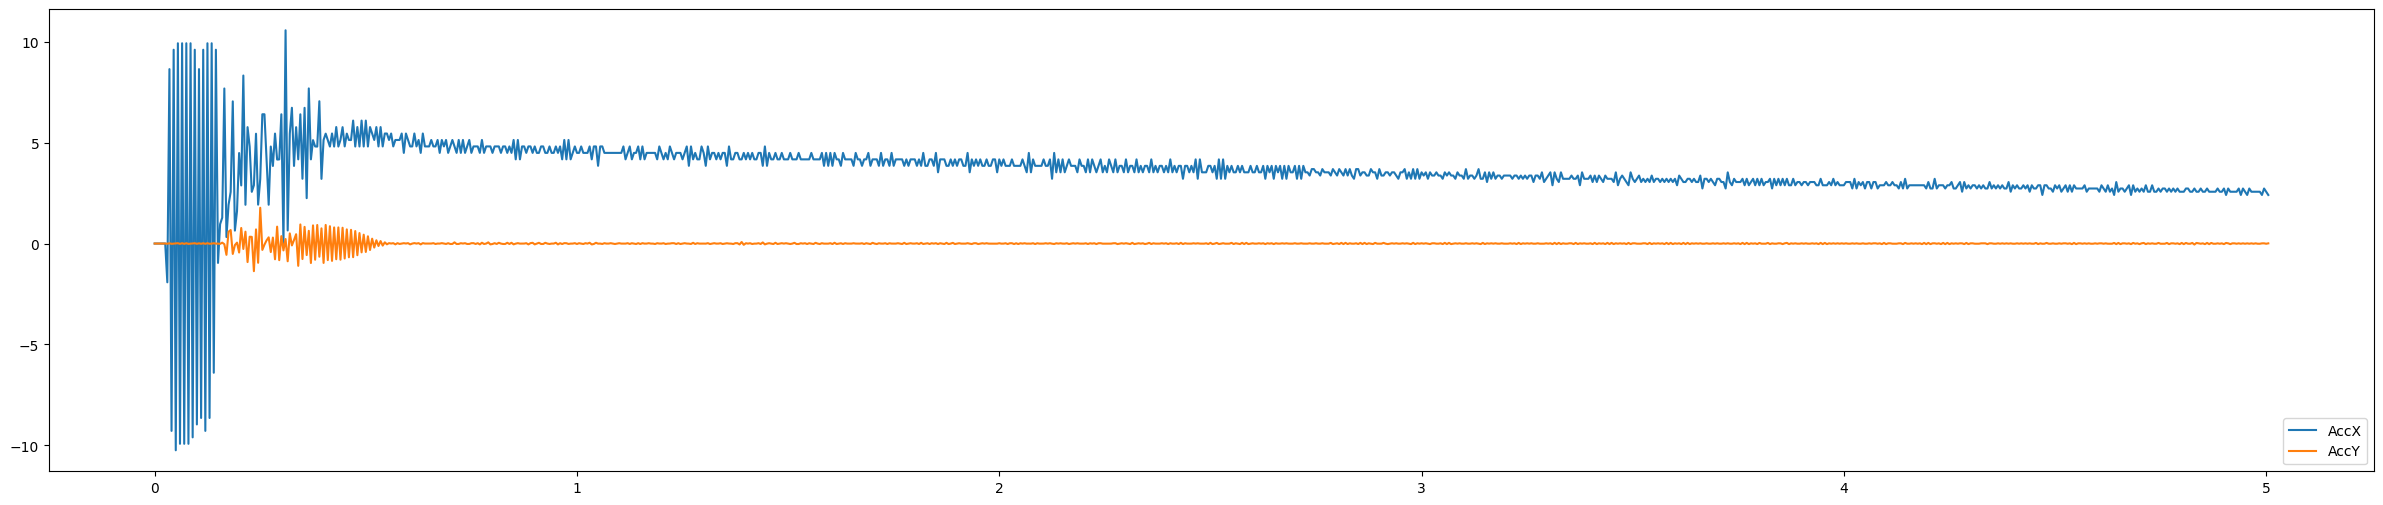

: 

In [18]:
plt.figure(figsize=(30,6))
plt.plot(time_array, np.array([d['AccX'] for d in imu_data], dtype=float), label='AccX')
plt.plot(time_array, np.array([d['AccY'] for d in imu_data], dtype=float), label='AccY')

plt.legend(loc="lower right")
plt.show()

In [ ]:
plt.figure(figsize=(30,6))
plt.title("Speed tracking for FTP-75")
plt.ylabel("Speed [km/h]")
plt.xlabel("Time [s]")
plt.plot(time_array, target_velocity_array, label='Target Vehicle Speed')
plt.plot(time_array, velocity_array, label='Real Vehicle Speed')
plt.legend(loc="lower right")
plt.show()

plt.figure(figsize=(30,6))
plt.title("Throttle and Brake during FTP-75 following")
plt.ylabel("Percentage [%]")
plt.xlabel("Time [s]")
plt.plot(time_array, 100 * np.array(throttle_array, dtype=float), label='Throttle')
plt.plot(time_array, -100 * np.array(brake_array, dtype=float), label='Brake')   
plt.legend(loc="lower right")
plt.show()

In [ ]:
imu_df = pd.read_csv(filename, sep=',', header=0)

t = np.array(imu_df['Time'], dtype=float)
accX = np.array(imu_df['AccX'], dtype=float)
accY = np.array(imu_df['AccY'], dtype=float)

In [ ]:
plt.figure(figsize=(30,6))
plt.title("Acceleration from IMU while tracking FTP-75")
plt.ylabel("Acceleration [m/s^2]")
plt.xlabel("Time [s]")
plt.xlim(85, 95)
plt.plot(t, np.sqrt(np.square(accX) + np.square(accY)), label='IMU acceleration')
plt.legend(loc="lower right")
plt.show()

plt.figure(figsize=(30,6))
plt.title("Direction of from IMU while tracking FTP-75")
plt.ylabel("Direction [°]")
plt.xlabel("Time [s]")
plt.xlim(85, 95)
plt.plot(t, np.array([math.atan2(accX[i], accY[i]) * 180 / np.pi for i in range(len(t))], dtype=float), label='Acceleratin direction')
plt.legend(loc="lower right")
plt.show()

plt.figure(figsize=(30,6))
plt.title("Direction of from IMU while tracking FTP-75")
plt.ylabel("Direction [°]")
plt.xlabel("Time [s]")
plt.xlim(85, 95)
plt.plot(t, accX, label='AccX')
plt.plot(t, accY, label='AccY')
plt.legend(loc="lower right")
plt.show()


plt.figure(figsize=(30,6))
plt.title("Speed tracking and T/B for FTP-75")
plt.ylabel("Speed [km/h] - Pressure[%]")
plt.xlabel("Time [s]")
plt.xlim(85, 95)
plt.plot(time_array, target_velocity_array, label='Target Vehicle Speed')
plt.plot(time_array, velocity_array, label='Real Vehicle Speed')
plt.plot(time_array, 100 * np.array(throttle_array, dtype=float), label='Throttle')
plt.plot(time_array, -100 * np.array(brake_array, dtype=float), label='Brake')  
plt.legend(loc="lower right")
plt.show()